In [40]:
import os

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import glob

from pathlib import Path

import scipy.stats as stats

from scipy import stats

import math

In [2]:
def t_test_values(input_BA): # give the input_BA as a string e.g. 'AEC'
    
    # get list of files from given BA
    list_of_hot_files = glob.glob(os.path.join(r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', f'{input_BA}_*.csv'))
    list_of_cold_files = glob.glob(os.path.join(r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD', f'{input_BA}_*.csv'))
    
    p_value_list = []
    # run for loop over list of the file names to return the t-test values
    for file_index in range(len(list_of_hot_files)):
        
        # read in csv files for hot and cold
        hot_df = pd.read_csv(list_of_hot_files[file_index], index_col = None, header = 0)
        hot_t2_array = hot_df['T2'].to_numpy()
        
        cold_df = pd.read_csv(list_of_cold_files[file_index], index_col = None, header = 0)
        cold_t2_array = cold_df['T2'].to_numpy()
        
        # get var for both hot and cold, to check if they have "equal" variance
        hot_var = np.var(hot_t2_array)
        cold_var = np.var(cold_t2_array)
        
        # check ratio of variances, then run the t-test if satisfied
        if hot_var > cold_var:
            if (hot_var / cold_var) > 4:
                print("The variances are unequal(ratio > 4)")
            else:
                t_stat, p_value = stats.ttest_ind(a = hot_t2_array, b = cold_t2_array, equal_var = True)
                
        else:
            if (cold_var / hot_var) > 4:
                print("The variances are unequal(ratio > 4)")
            else:
                t_stat, p_value = stats.ttest_ind(a = hot_t2_array, b = cold_t2_array, equal_var = True)
                
        # add p value to list for every year
        p_value_list.append(p_value)
    
    # return a list of the p values of each t-test
    return p_value_list

In [3]:
# run through t_test_values for every BA. return a list of the BAs where there exists a p-value greater than the input
def p_value_BA(input_p_value): # input the input_p_value as a float e.g. 0.05
    
    # get a list of the BAs
    list_of_files = glob.glob(os.path.join(r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', "*.csv"))
    
    # get a list of unique BA names
    BA_names = []
    for file_index in range(len(list_of_files)):
        base_name = os.path.splitext(os.path.basename(list_of_files[file_index]))[0]
        split = base_name.split("_")
        if split[0] in BA_names:
            pass
        else:
            BA_names.append(split[0])
    
    insignificant_BA_list = []
    p_values = []
    # run t_test_values for each BA
    for BA in BA_names:
        p_value_list = t_test_values(BA)
        
        # check p values
        for p_value in p_value_list:
            if p_value > input_p_value:
                insignificant_BA_list.append(BA)
                p_values.append(p_value)
                break
            
    # return a list of BAs where there exists a year which would accept the null hypothesis that the difference in group means is zero
    return insignificant_BA_list, p_values

In [4]:
list_BA, list_p_value = p_value_BA(0.04)

In [5]:
# return a dataframe where each BA has an associated year where the null hypothesis switches from being accepted to rejected
def year_of_rejection(list_of_BA): # input the list_of_BA as a list of strings, each string a BA e.g. ['AEC','CPLE','DUK']
    
    # create list of possible years to reference
    years_list = list(range(20, 99))
    
    significant_indexes = []
    # run through BA names to get index of when p-value switches to significant
    for BA_name in list_of_BA:
        p_value_list = t_test_values(BA_name)
        
        # check when the p-value gets below certain
        for p_value in range(len(p_value_list)):
            if p_value_list[p_value] < 0.04:
                significant_indexes.append(p_value)
                break
    
    # align the years_list with the significant idexes
    significant_years = []
    for index in significant_indexes:
        significant_years.append(years_list[index])
        
    return significant_years

In [6]:
years_rejection = year_of_rejection(list_BA)

In [7]:
years_df = pd.DataFrame(years_rejection, columns = ["Year"])
years_df['BA'] = list_BA
years_df['P_Value'] = list_p_value
years_df = years_df[['BA', 'Year', 'P_Value']]
years_df

,BA,Year,P_Value
0,AEC,21,0.049156
1,CPLE,21,0.054969
2,DUK,21,0.073358
3,ERCO,21,0.148800
4,FPC,21,0.041901
5,GVL,21,0.041665
6,JEA,21,0.048265
7,LGEE,21,0.090001
8,NSB,21,0.063863
9,OVEC,21,0.267471


Okay it seems like what I'm testing is not that useful, as we should expect this result that the means are different. It is probably better to do stuff surrounding how different they are. With such a large sample, we can be pretty confident that the sample mean more closely resembles the population mean, and the two-sample t-test which tests for difference in means is obviously satisfied. 

Statistics=0.994, p=0.000
 Sample does not look Gaussian (reject H0)
Statistics=136.088, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 15.240
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


C:\projects\tell_3p10\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


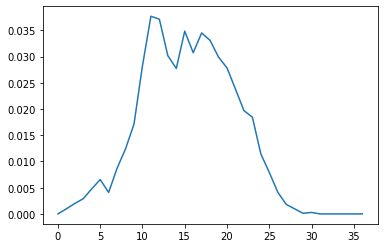

In [8]:
# run the three normality tests for a single year, they all return not normal
df = pd.read_csv(r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD\AVA_WRF_Hourly_Mean_Meteorology_2020.csv', index_col = None, header = 0)
t2_bins = np.arange(250,325,2)
hist, bin_edges = np.histogram(df['T2'], bins = t2_bins, density = True)
plt.plot(hist)

# run shapiro-wilks test, which supposedly works better with n < 5000 observations
stat, p = stats.shapiro(df['T2'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print(' Sample looks Gaussian (fail to reject H0)')
else:
    print(' Sample does not look Gaussian (reject H0)')
    
# run normal test, which measures skew(left or right) and kurtosis(data in the tails)
stat2, p2 = stats.normaltest(df['T2'])
print('Statistics=%.3f, p=%.3f' % (stat2, p2))
if p2 > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
    
# run anderson-darling test, returning critical values to evaluate against normal
result = stats.anderson(df['T2'])
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

In [9]:
def data_chunk(first_year, files_path, input_BA): # input first_year as an integer: the first year of the decade you want e.g. 2020. input file_path as a raw string directory
                                                       # e.g. r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT' . input input_BA as a string e.g. 'AEC'
    # get a list of the files from the path
    list_of_files = glob.glob(os.path.join(files_path, f'{input_BA}_*.csv'))
    
    # get a list of the elements of each file name
    BA_list_split = []
    for file_index in range(len(list_of_files)):
        base_name = os.path.splitext(os.path.basename(list_of_files[file_index]))[0]
        split = base_name.split("_")
        BA_list_split.append(split)

    # get a list of the BA names, with the same indexes as their original file names
    BA_names = []
    for file_list in BA_list_split:
        BA_names.append(file_list[0])
        
    # get the first file with which to start pulling hourly data
    for file_index in range(len(list_of_files)):
        if input_BA == BA_names[file_index]:
            if str(first_year) in list_of_files[file_index]:
                first_file = list_of_files[file_index]
                break
                
    # get a list of the 10 files to unpack
    index_first_file = list_of_files.index(first_file)
    decade_file_list = []
    for file in list_of_files[index_first_file:]:
        if len(decade_file_list) == 10:
            break
        decade_file_list.append(file)
        
    # create aggregate df of all t2 values from each file_name df
    t2_bins = np.arange(250,325,2)
    for file_name in range(len(decade_file_list)):
        
        # read in the file as a df
        df = pd.read_csv(decade_file_list[file_name], index_col = None, header = 0)
        
        # aggregate output into a new dataframe:
        if file_name == 0:
            aggregate_output_df = df
        else:
            aggregate_output_df = pd.concat([aggregate_output_df, df], axis = 0)
            
    return aggregate_output_df

C:\projects\tell_3p10\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistics=0.987, p=0.000
 Sample does not look Gaussian (reject H0)
Statistics=21120.176, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 2454.909
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


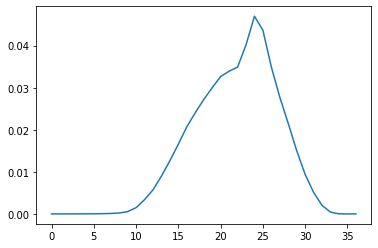

In [12]:
# gather 80 years of data to see if more data points better approximates to normal - 700,000 T2 values
hot_80 = pd.concat([data_chunk(2020, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC'), 
                   data_chunk(2030, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC'),
                   data_chunk(2040, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC'),
                   data_chunk(2050, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC'),
                   data_chunk(2060, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC'),
                   data_chunk(2070, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC'),
                   data_chunk(2080, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC'),
                   data_chunk(2090, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC')], axis = 0)

# create histogram of hot_80
t2_bins = np.arange(250,325,2)
hist, bin_edges = np.histogram(hot_80['T2'], bins = t2_bins, density = True)
plt.plot(hist)

# run the three tests on hot_80, given the histogram looks at least a little gaussian
alpha = 0.05
stat, p = stats.shapiro(hot_80['T2'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
    print(' Sample looks Gaussian (fail to reject H0)')
else:
    print(' Sample does not look Gaussian (reject H0)')
    
stat2, p2 = stats.normaltest(hot_80['T2'])
print('Statistics=%.3f, p=%.3f' % (stat2, p2))
if p2 > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
    
result = stats.anderson(hot_80['T2'])
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

In [ ]:
# list_of_cold_files = glob.glob(os.path.join(r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD', "*.csv"))

#for file in list_of_cold_files:
    # df = pd.read_csv(file, index_col = None, header = 0)
    # name = os.path.basename(file)
    # stat, p = shapiro(df['T2'])
    # alpha = 0.05
    # print('Statistics=%.3f, p=%.3f' % (stat, p))
    # if p > alpha:
        # print(name + ' Sample looks Gaussian (fail to reject H0)')
    # else:
        # print(name + ' Sample does not look Gaussian (reject H0)')

In [23]:
hot_aec_2020 = pd.read_csv(r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT\AEC_WRF_Hourly_Mean_Meteorology_2020.csv', index_col = None, header = 0)
cold_aec_2020 = pd.read_csv(r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD\AEC_WRF_Hourly_Mean_Meteorology_2020.csv', index_col = None, header = 0)

def cohen_d(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

d = cohend(hot_aec_2020['T2'], cold_aec_2020['T2'])
print('Cohens d: %.3f' % d)

Cohens d: 0.030


In [24]:
hot_aec_2060 = pd.read_csv(r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT\AEC_WRF_Hourly_Mean_Meteorology_2060.csv', index_col = None, header = 0)
cold_aec_2060 = pd.read_csv(r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD\AEC_WRF_Hourly_Mean_Meteorology_2060.csv', index_col = None, header = 0)

d2 = cohend(hot_aec_2060['T2'], cold_aec_2060['T2'])
print('Cohens d: %.3f' % d2)

Cohens d: 0.121


In [31]:
def cohen_d_BA(input_BA): # do input_BA as a string e.g. 'AEC'
    
    # get list of files for each scenario
    list_of_hot_files = glob.glob(os.path.join(r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', f'{input_BA}_*.csv'))
    list_of_cold_files = glob.glob(os.path.join(r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD', f'{input_BA}_*.csv'))
    
    # prepare dataframe for cohen's d
    years_list = list(range(20, 100))
    cohen_d_df = pd.DataFrame(years_list, columns = ['Year'])
    
    all_cohen_d = []
    # run a for loop returning Cohen's d for each year
    for file_index in range(len(list_of_hot_files)):
        hot_df = pd.read_csv(list_of_hot_files[file_index])
        cold_df = pd.read_csv(list_of_cold_files[file_index])
        
        # call cohen_d function for each year
        year_cohen_d = cohen_d(hot_df['T2'], cold_df['T2'])
        all_cohen_d.append(year_cohen_d)
        
    # add all_cohen_d to dataframe
    cohen_d_df['Cohen_d'] = all_cohen_d
    
    return cohen_d_df

In [38]:
azps = cohen_d_BA('AZPS')

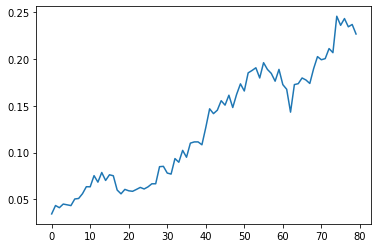

In [39]:
plt.plot(azps['Cohen_d'])

In [46]:
t2_log = []
#for num in hot_aec_2020['T2']:
    #t2_log.append(math.log(num))
    #hot_aec_2020['T2_Log'] = t2_log
   
np.log(hot_aec_2020['T2'])


0       5.641375
1       5.640310
2       5.638959
3       5.637607
4       5.636110
          ...   
8778    5.661084
8779    5.662578
8780    5.662231
8781    5.658506
8782    5.649573
Name: T2, Length: 8783, dtype: float64

In [47]:
def cohen_d_BA_test(input_BA): # do input_BA as a string e.g. 'AEC'
    
    # get list of files for each scenario
    list_of_hot_files = glob.glob(os.path.join(r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', f'{input_BA}_*.csv'))
    list_of_cold_files = glob.glob(os.path.join(r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD', f'{input_BA}_*.csv'))
    
    # prepare dataframe for cohen's d
    years_list = list(range(20, 100))
    cohen_d_df = pd.DataFrame(years_list, columns = ['Year'])
    
    np.log(hot_aec_2020['T2'])
    all_cohen_d = []
    # run a for loop returning Cohen's d for each year
    for file_index in range(len(list_of_hot_files)):
        hot_df = pd.read_csv(list_of_hot_files[file_index])
        cold_df = pd.read_csv(list_of_cold_files[file_index])
        
        hot_df_log = np.log(hot_df['T2'])
        cold_df_log = np.log(cold_df['T2'])
        
        # call cohen_d function for each year
        year_cohen_d = cohen_d(hot_df_log['T2'], cold_df_log['T2'])
        all_cohen_d.append(year_cohen_d)
        
    # add all_cohen_d to dataframe
    cohen_d_df['Cohen_d'] = all_cohen_d
    
    return cohen_d_df

In [48]:
azps2 = cohen_d_BA('AZPS')

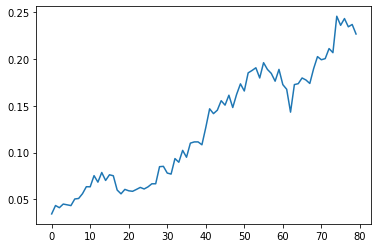

In [49]:
plt.plot(azps2['Cohen_d'])

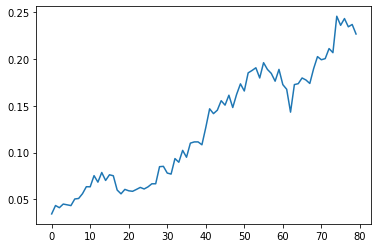

In [50]:
plt.plot(azps['Cohen_d'])

C:\projects\tell_3p10\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
C:\projects\tell_3p10\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistics=0.987, p=0.000
 Sample does not look Gaussian (reject H0)
Statistics=21120.176, p=0.000
Sample does not look Gaussian (reject H0)
Statistic: 2454.909
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


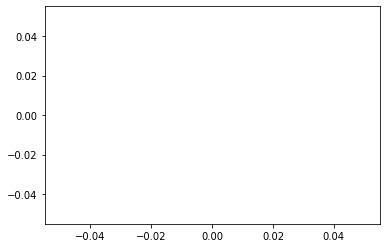

In [58]:
# gather 80 years of data to see if more data points better approximates to normal - 700,000 T2 values
hot_80 = pd.concat([data_chunk(2020, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC'), 
                   data_chunk(2030, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC'),
                   data_chunk(2040, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC'),
                   data_chunk(2050, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC'),
                   data_chunk(2060, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC'),
                   data_chunk(2070, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC'),
                   data_chunk(2080, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC'),
                   data_chunk(2090, r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', 'AEC')], axis = 0)



# create histogram of hot_80
t2_bins = np.arange(250,325,2)
hist, bin_edges = np.histogram(hot_80_log, bins = t2_bins, density = True)
plt.plot(hist)

# run the three tests on hot_80, given the histogram looks at least a little gaussian
alpha = 0.05
stat, p = stats.shapiro(hot_80_log)
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
    print(' Sample looks Gaussian (fail to reject H0)')
else:
    print(' Sample does not look Gaussian (reject H0)')
    
stat2, p2 = stats.normaltest(hot_80_log)
print('Statistics=%.3f, p=%.3f' % (stat2, p2))
if p2 > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
    
result = stats.anderson(hot_80_log)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

In [63]:
np.histogram(hot_80_log)

(array([    66,    565,   9003,  45031,  98122, 138998, 175992, 159109,
         65412,   8979], dtype=int64),
 array([0.00103433, 0.0010599 , 0.00108548, 0.00111105, 0.00113662,
        0.0011622 , 0.00118777, 0.00121335, 0.00123892, 0.00126449,
        0.00129007]))

In [64]:
plot(np.histogram(hot_80_log))

NameError: name 'plot' is not defined

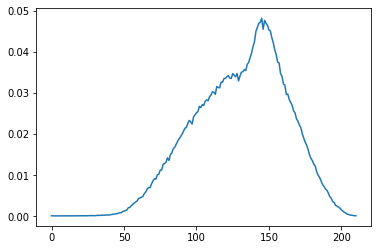

In [72]:

hot_80_log = np.log(hot_80['T2'])





hist, bin_edges = np.histogram(hot_80['T2'],bins = 'auto', density = True)
plt.plot(hist)